In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
colar_pal = sns.color_palette()

In [59]:
df = pd.read_csv('Dataset/PJME_hourly.csv')

In [60]:
df =df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

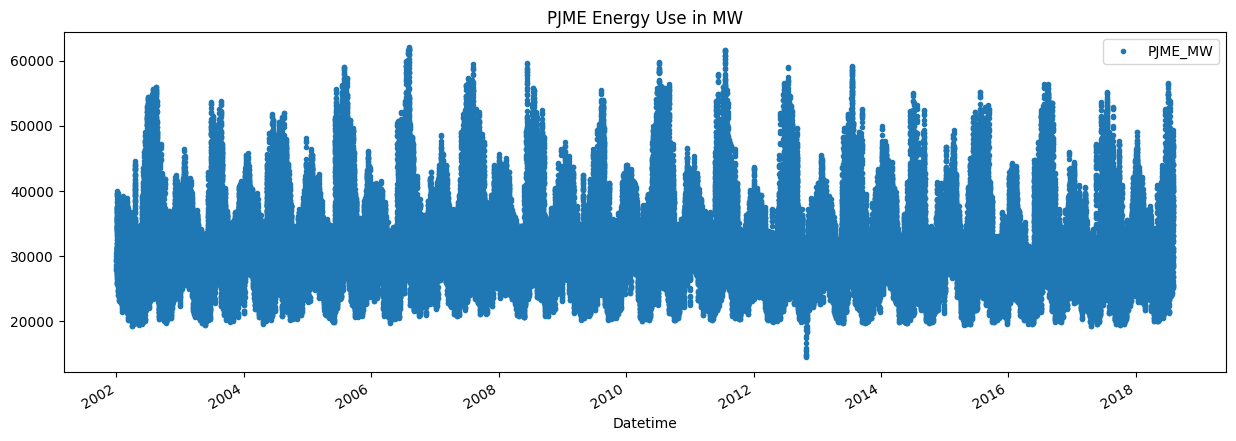

In [61]:
df.plot(style='.',figsize=(15,5),color=colar_pal[0],title='PJME Energy Use in MW')
plt.savefig('Pictures/Energy_Consumption_plot.png')

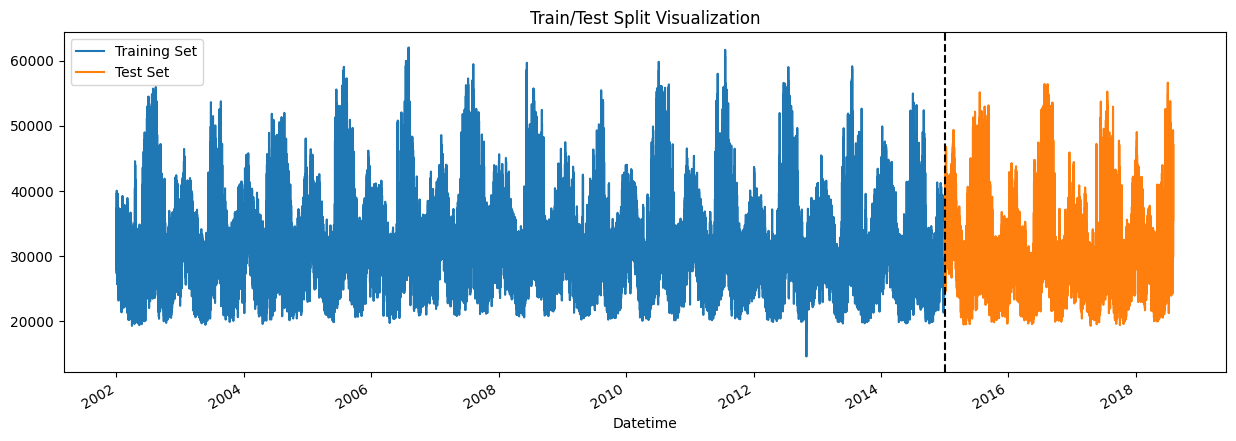

<Figure size 640x480 with 0 Axes>

In [62]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig,ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set',title='Train/Test Split Visualization')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015',color='black',ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

plt.savefig('Pictures/Test_Train_Plot.png')


In [63]:
#Feature Creation

In [64]:
def create_features(df):
    df = df.copy()
    df['hour']=df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [65]:
df = create_features(df)

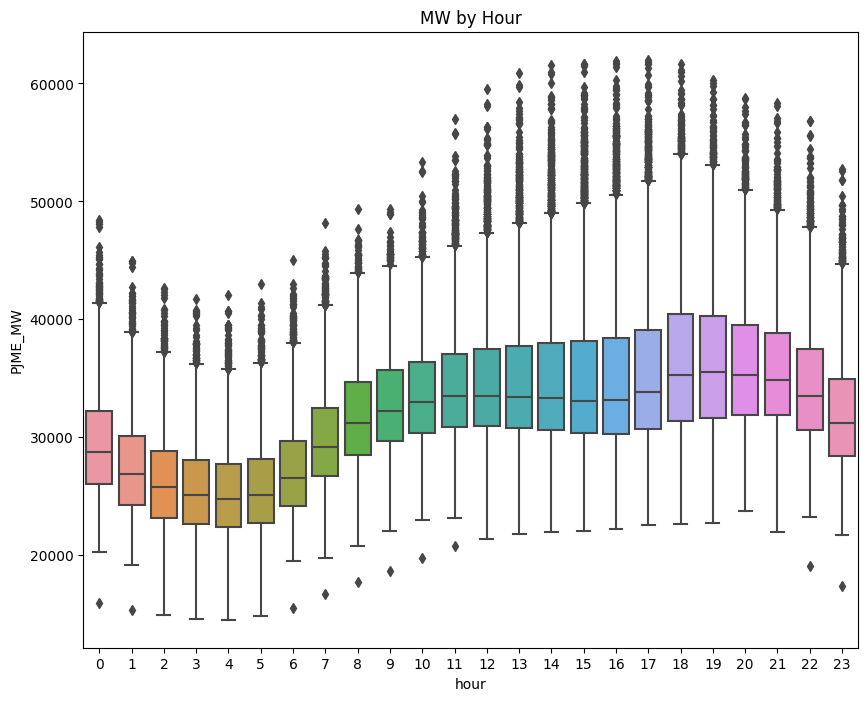

In [66]:
fig,ax = plt.subplots(figsize= (10,8))
sns.boxplot(data=df,x='hour',y='PJME_MW')
ax.set_title('MW by Hour')
plt.savefig('Pictures/VisualizeRelationshipHour.png')


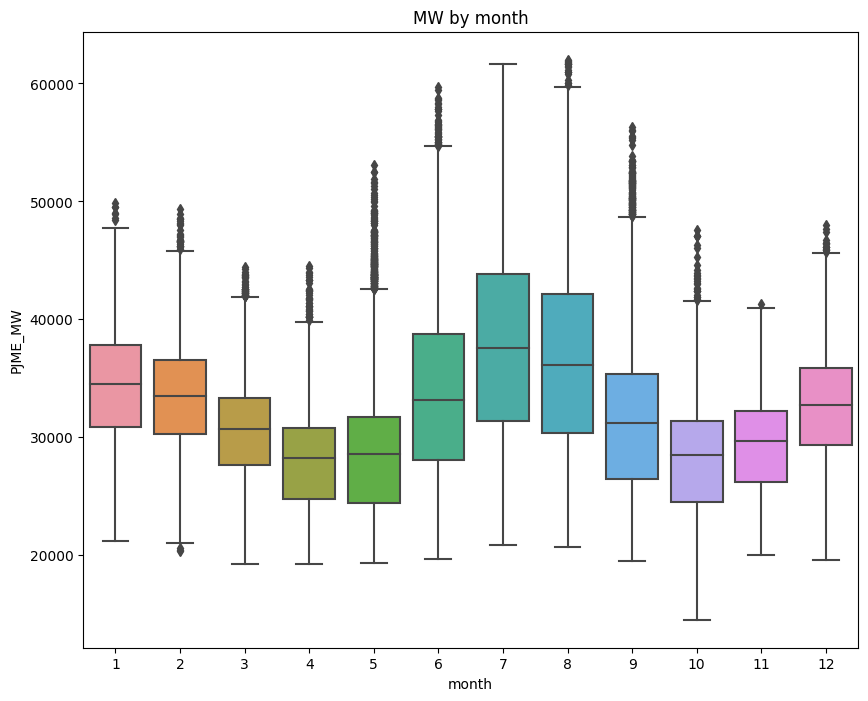

In [67]:
fig,ax = plt.subplots(figsize= (10,8))
sns.boxplot(data=df,x='month',y='PJME_MW')
ax.set_title('MW by month')
plt.savefig('Pictures/VisualizeRelationshipMonth.png')


In [68]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek','quarter','month','year','dayofyear']
TARGET = 'PJME_MW'

In [69]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [70]:
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds =50,learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set = [(X_train,y_train), (X_test,y_test)],verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[451]	validation_0-rmse:2771.05175	validation_1-rmse:3731.37067


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [71]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi

,importance
hour,0.448804
dayofweek,0.158668
quarter,0.033319
month,0.228156
year,0.022634
dayofyear,0.108419


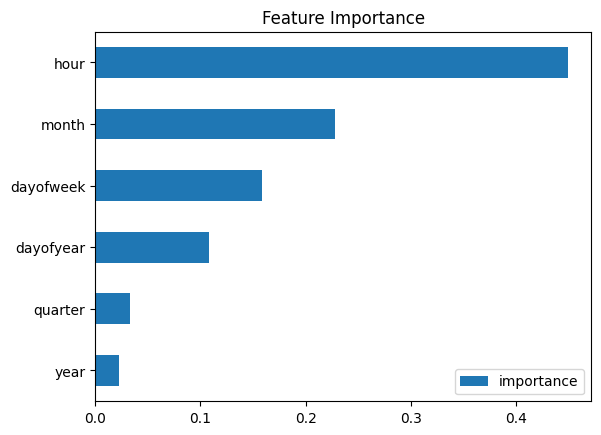

<Figure size 640x480 with 0 Axes>

In [72]:
fi.sort_values('importance').plot(kind='barh',title='Feature Importance')
plt.show()
plt.savefig('Pictures/FeatureImportance.png')

In [73]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']],how='left',left_index=True,right_index=True)

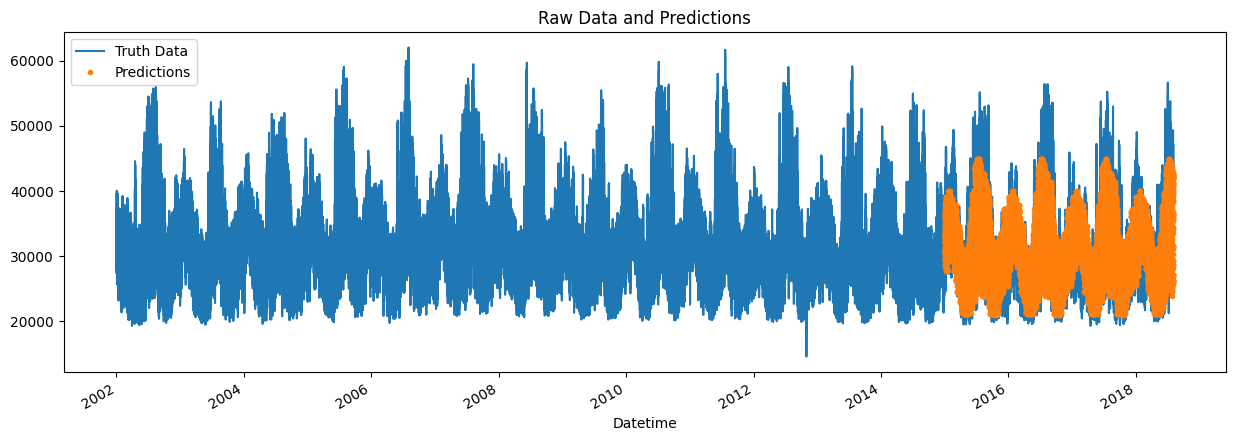

<Figure size 640x480 with 0 Axes>

In [76]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax,style='.')
plt.legend(['Truth Data','Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()
plt.savefig('Pictures/RawVSPrediction')